# Bayesian network model of predator-prey interactions

## 1. Description

Here, I build a Bayesian network implementation of the DAG where there is no feedback between the predator and the prey's behavior within a match.

Our objective is to use causal inference to model the predator-prey interaction as it changes throughout the predator's experience. Our DAG explains how we expect the system to work.

## 2. Prepare the session

I start by importing the librairies that I'll need to build the network.

In [1]:
# For Bayesian networks
import bnlearn as bn

# For data manipulations
from pathlib import Path
import pandas as pd
import numpy as np

# For ploting
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

## 3. Import the data

I import the data to build the network.

In [2]:
# Specify the parent folder
notebook_dir = Path.cwd()
parent_folder = notebook_dir.parent.parent

# Data path
data_subfolder = "data"
file_name = "FraserFranco-etal-XXXX.csv"

# Full path to data file
file_path = parent_folder / data_subfolder / file_name

# Import dataset
dat = pd.read_csv(file_path, index_col = None)

### 3.1 Visualize the data structure

Let's start by checking the data

In [3]:
dat.head()

,match_id,predator_id,xp_level,timestamp,game_mode,realm_id,environment_id,avatar_id,game_duration,prey_avg_rank,...,chase_count,chase_count_success,attacks_count,prey_avg_heal_count,prey_var_heal_count,chase_success_ratio,prior_prey_speed,prior_prey_heal,prior_success,time_lag
0,DHCF1PHC,pred100494,novice,2021-01-02 14:47:16,Online,Yamaoka Estate,Family Residence,Wraith,399.848999,11.75,...,5,1,2,1.25,3.583333,0.2,NaN,NaN,NaN,NaN
1,BHJFA1I0,pred100494,novice,2021-01-02 14:57:02,Online,The Macmillan Estate,Groaning Storehouse,Wraith,319.134979,11.75,...,8,0,0,0.00,0.000000,0.0,2.129557,1.25,0.0,9.766133
2,PMM9CDDR,pred100494,novice,2021-01-02 15:08:18,Online,Silent Hill,Midwich Elementary School,Doctor,687.513123,15.25,...,19,0,6,1.75,0.916667,0.0,2.278671,0.00,0.0,11.271783
3,3NT75SH7,pred100494,novice,2021-01-02 15:30:29,Online,Autohaven Wreckers,Blood Lodge,Huntress,528.620361,11.25,...,11,0,7,1.75,1.583333,0.0,1.962961,1.75,0.0,22.176050
4,MNL0ZWA5,pred100494,novice,2021-01-02 15:46:26,Online,Grave of Glenvale,Dead Dawg Saloon,Hillbilly,409.839844,14.50,...,4,0,0,0.00,0.000000,0.0,2.415156,1.75,0.0,15.946550


In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               100062 non-null  object 
 1   predator_id            100062 non-null  object 
 2   xp_level               100062 non-null  object 
 3   timestamp              100062 non-null  object 
 4   game_mode              100062 non-null  object 
 5   realm_id               100062 non-null  object 
 6   environment_id         100062 non-null  object 
 7   avatar_id              100062 non-null  object 
 8   game_duration          100062 non-null  float64
 9   prey_avg_rank          100062 non-null  float64
 10  total_xp_pred          100062 non-null  int64  
 11  cumul_xp_pred          100062 non-null  int64  
 12  hunting_success        100062 non-null  int64  
 13  points_predator        100062 non-null  int64  
 14  pred_speed             100062 non-nu

In [5]:
print("Colum names:", dat.columns)

Colum names: Index(['match_id', 'predator_id', 'xp_level', 'timestamp', 'game_mode',
       'realm_id', 'environment_id', 'avatar_id', 'game_duration',
       'prey_avg_rank', 'total_xp_pred', 'cumul_xp_pred', 'hunting_success',
       'points_predator', 'pred_speed', 'prey_avg_speed',
       'predicted_mean_speed', 'predicted_sigma_speed', 'cluster',
       'hunting_type', 'chase_count', 'chase_count_success', 'attacks_count',
       'prey_avg_heal_count', 'prey_var_heal_count', 'chase_success_ratio',
       'prior_prey_speed', 'prior_prey_heal', 'prior_success', 'time_lag'],
      dtype='object')


## 4. Build the Bayesian network

Here, I use my expertise and knowledge of the system to build the network. In this manuscript, we suggest a causal model of predator-prey interactions, and we thus build our model based on our beliefs on how the system works.

### 4.1 Select variables for the Bayesian network

I start by subsetting the variables that I will use for the model.

In [25]:
# Discretize the continous columns
dat["prey_avg_speed_bin"] = pd.qcut(
    x = dat.prey_avg_speed,
    q = 5
)

dat["time_lag_bin"] = pd.qcut(
    x = dat.time_lag,
    q = 5
)

# Select relevant variables
selected_variables = [
    "xp_level",
    "hunting_type",
    "hunting_success",
    "prey_avg_speed_bin",
    "prior_success",
    "time_lag_bin"
]

# Subset the data
subset = dat[selected_variables]
subset

# Drop the first row for every player ID (NaN)
subset = subset.dropna()

# Convert success to integer again
subset['prior_success'] = subset['prior_success'].round().astype(int)

### 4.2 Build the Bayesian network structure

Here, I build the relationships (edges) between the variables (nodes).

The model goes like this :

experience --> hunting type --> hunting success

prior prey speed --> hunting_type

prior success --> hunting_type

time lag --> hunting_type

hunting type --> prey speed

prey speed --> hunting success

In [26]:
edges = [
    ("xp_level", "hunting_type"),
    ("prior_success", "hunting_type"),
    ("time_lag_bin", "hunting_type"),
    ("hunting_type", "hunting_success"),
    ("hunting_type", "prey_avg_speed_bin"),
    ("prey_avg_speed_bin", "hunting_success")
]

In [27]:
subset.head()

,xp_level,hunting_type,hunting_success,prey_avg_speed_bin,prior_success,time_lag_bin
1,novice,ambush-flexible,0,"(2.153, 2.35]",0,"(5.96, 14.699]"
2,novice,ambush-flexible,0,"(0.619, 2.153]",0,"(5.96, 14.699]"
3,novice,ambush-flexible,0,"(2.35, 2.506]",0,"(18.035, 25.191]"
4,novice,ambush-flexible,0,"(0.619, 2.153]",0,"(14.699, 18.035]"
5,novice,ambush-flexible,0,"(2.35, 2.506]",0,"(359.33, 201831.686]"


Now I build the dag using the edges object

In [28]:
DAG = bn.make_DAG(edges)

[bnlearn] >bayes DAG created.


And I fit the model using the DAG that I constructed. I use the Bayes method.

In [30]:
DAG = bn.parameter_learning.fit(
    DAG, subset,
    methodtype = "bayes"
)

[bnlearn] >Parameter learning> Computing parameters using [bayes]


[bnlearn] >CPD of xp_level:
+--------------------+----------+
| xp_level(advanced) | 0.305055 |
+--------------------+----------+
| xp_level(interm)   | 0.46272  |
+--------------------+----------+
| xp_level(novice)   | 0.232225 |
+--------------------+----------+
[bnlearn] >CPD of hunting_type:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of prior_success:
+------------------+----------+
| prior_success(0) | 0.220179 |
+------------------+----------+
| prior_success(1) | 0.190181 |
+------------------+----------+
| prior_success(2) | 0.152705 |
+------------------+----------+
| prior_success(3) | 0.18907  |
+------------------+----------+
| prior_success(4) | 0.247865 |
+------------------+----------+
[bnlearn] >CPD of time_lag_bin:
+------------------------------------+----------+
| time_lag_bin((5.96, 14.699])       | 0.200002 |
+------------------------------------+----------+
| time_lag_bin((14.699, 18.035]

I do the chi-square test to evaluate edge strength

In [36]:
# Convert to onehot
dfhot, dfnum = bn.df2onehot(subset)

# Compute edge strength with the chi_square test statistic
DAG = bn.independence_test(
    DAG,
    dfnum,
    test = "chi_square",
    prune = False
)
DAG


[df2onehot] >Auto detecting dtypes.


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 6/6 [00:00<00:00, 38.99it/s]

[df2onehot] >Total onehot features: 18
[bnlearn] >Compute edge strength with [chi_square]


{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x71277c829cc0>,
 'adjmat': target              xp_level  hunting_type  prior_success  time_lag_bin  \
 source                                                                    
 xp_level               False          True          False         False   
 hunting_type           False         False          False         False   
 prior_success          False          True          False         False   
 time_lag_bin           False          True          False         False   
 hunting_success        False         False          False         False   
 prey_avg_speed_bin     False         False          False         False   
 
 target              hunting_success  prey_avg_speed_bin  
 source                                                   
 xp_level                      False               False  
 hunting_type                   True                True  
 prior_success                 False               False  
 time_lag

I can check the full Conditional probability distribution

In [22]:
bn.print_CPD(DAG)

[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    | xp_level   |        p |
+====+============+==========+
|  0 | advanced   | 0.305055 |
+----+------------+----------+
|  1 | interm     | 0.46272  |
+----+------------+----------+
|  2 | novice     | 0.232225 |
+----+------------+----------+
CPD of xp_level:
+--------------------+----------+
| xp_level(advanced) | 0.305055 |
+--------------------+----------+
| xp_level(interm)   | 0.46272  |
+--------------------+----------+
| xp_level(novice)   | 0.232225 |
+--------------------+----------+
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+-----+---------------------------+-----------------+----------------------+------------+----------+
|     | hunting_type              |   prior_success | time_lag_bin         | xp_level   |        p |
+=====+===========================+=================+=====

{'xp_level':    xp_level         p
 0  advanced  0.305055
 1    interm  0.462720
 2    novice  0.232225,
 'hunting_type':                   hunting_type  prior_success          time_lag_bin  xp_level  \
 0              ambush-flexible            0.0        (5.96, 14.699]  advanced   
 1              ambush-flexible            0.0        (5.96, 14.699]    interm   
 2              ambush-flexible            0.0        (5.96, 14.699]    novice   
 3              ambush-flexible            0.0      (14.699, 18.035]  advanced   
 4              ambush-flexible            0.0      (14.699, 18.035]    interm   
 ..                         ...            ...                   ...       ...   
 220  intercepting-intermediate            4.0      (25.191, 359.33]    interm   
 221  intercepting-intermediate            4.0      (25.191, 359.33]    novice   
 222  intercepting-intermediate            4.0  (359.33, 201831.686]  advanced   
 223  intercepting-intermediate            4.0  (359.33, 20

Testing a plot

[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.


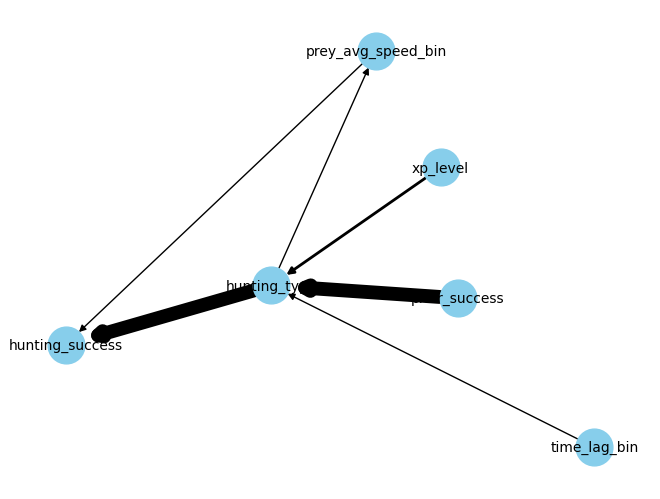

In [65]:
# Get edge properties from the DAG
edge_properties = bn.get_edge_properties(DAG)

# Create a directed graph
G = nx.DiGraph()

# Add edges with sizes based on chi-square test results
for edge, properties in edge_properties.items():
    strength = properties.get('weight', 0)  # Use 'weight' as the correct attribute name
    G.add_edge(*edge, weight=strength)

# Round the edge weights to 1 digit
rounded_edge_labels = {(u, v): round(properties['weight'], 1) for (u, v), properties in edge_properties.items()}

# Draw the graph with rounded edge sizes and without weight labels
pos = nx.spring_layout(G)  # You can choose a different layout if needed
nx.draw(
    G, pos, with_labels=True, node_size=700,
    node_color="skyblue", font_size=10, font_color="black",
    width=[G[u][v]['weight'] for u, v in G.edges()]
    #width = [2*G[u][v]['weight'] for u, v in G.edges()]
    )

plt.show()

[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.


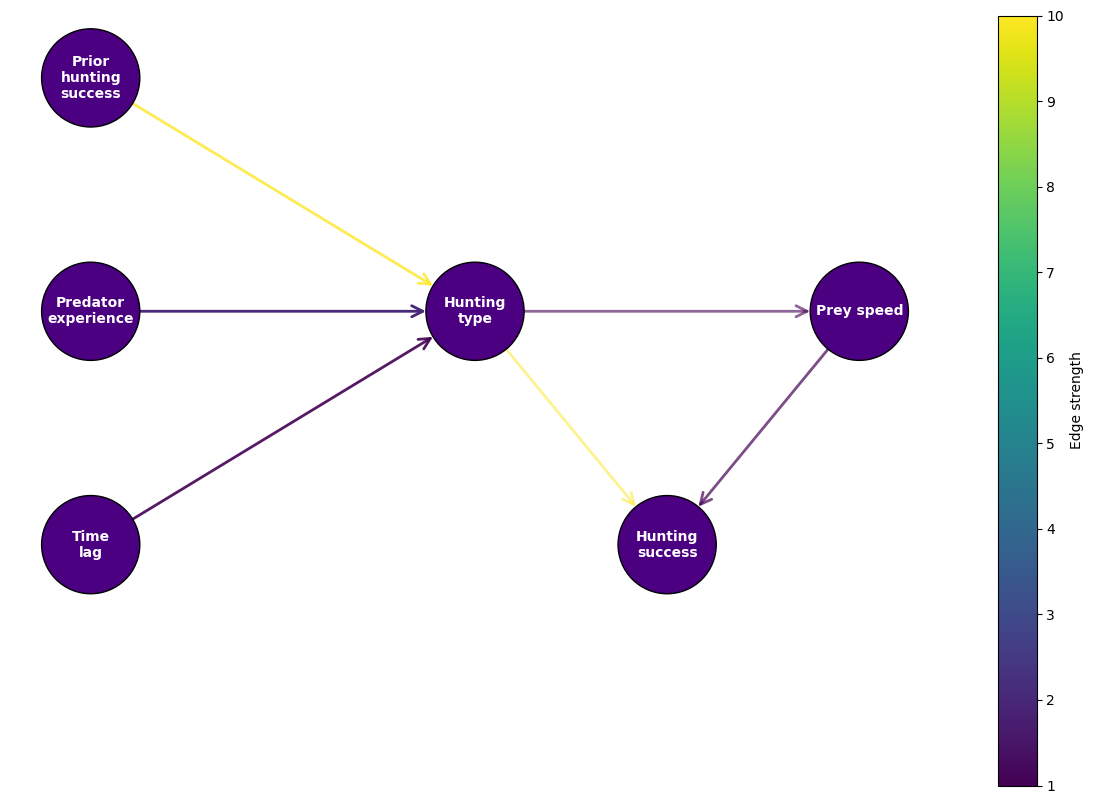

In [110]:
# Get edge properties from the DAG
edge_properties = bn.get_edge_properties(DAG)

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights based on chi-square test results
for edge, properties in edge_properties.items():
    strength = properties.get("weight", 0)
    G.add_edge(*edge, weight = strength)

# Manually specify node names
node_mapping = {
    "hunting_type": "Hunting\ntype",
    "hunting_success": "Hunting\nsuccess",
    "prey_avg_speed_bin": "Prey speed",
    "prior_success": "Prior\nhunting\nsuccess",
    "time_lag_bin": "Time\nlag",
    "xp_level": "Predator\nexperience"
}
G = nx.relabel_nodes(G, node_mapping)

# Define positions for the nodes
pos = {
    "Predator\nexperience": (0.5, 0),
    "Prior\nhunting\nsuccess": (0.5, 0.005),
    "Time\nlag": (0.5, -0.005),
    "Hunting\ntype": (1, 0),
    "Prey speed": (1.5, 0),
    "Hunting\nsuccess": (1.25, -0.005),
}

# Set a fixed larger size for nodes
node_size = 5000
node_sizes = [node_size for _ in range(len(G))]

# Define edge colors and transparency
M = G.number_of_edges()
edge_colors = [properties["weight"] for u, v, properties in G.edges(data = True)]
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

# Use viridis colormap
cmap = plt.cm.viridis

# Plot size
plt.figure(figsize = (15, 10))

# Draw the DAG
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size = node_sizes,
    node_color = "indigo",
    edgecolors = "black"
)

edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size = node_sizes,
    arrowstyle = "->",
    arrowsize = 20,
    edge_color = edge_colors,
    edge_cmap = cmap,
    width = 2,
)

# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap = cmap)
pc.set_array(edge_colors)

# Display node labels
node_labels = nx.draw_networkx_labels(
    G, pos,
    font_size = 10, font_weight = "bold",
    font_color = "white"
)

# Display the figure
ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax = ax, label = "Edge strength")
plt.show()